<a href="https://colab.research.google.com/github/tmurad2/AML-Project/blob/main/aml_obj_det.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pycocotools

In [2]:

import os
os.chdir("/content/drive/MyDrive/GoogleColab/Code/AML_OBJ_DET/od_dir")

In [ ]:
%%bash
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
Checking out files: 100% (541/541), done.
error: Your local changes to the following files would be overwritten by checkout:
	.circleci/build_docs/commit_docs.sh
	.circleci/regenerate.py
	.circleci/unittest/linux/scripts/install.sh
	.circleci/unittest/linux/scripts/post_process.sh
	.circleci/unittest/linux/scripts/run-clang-format.py
	.circleci/unittest/linux/scripts/run_test.sh
	.circleci/unittest/linux/scripts/setup_env.sh
	packaging/build_cmake.sh
	packaging/build_conda.sh
	packaging/build_wheel.sh
	packaging/conda/build_vision.sh
	packaging/conda/switch_cuda_version.sh
Please commit your changes or stash them before you switch branches.
Aborting


In [ ]:
%%bash
git clone https://github.com/experiencor/raccoon_dataset.git


Cloning into 'raccoon_dataset'...
Checking out files: 100% (419/419), done.


In [3]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [4]:
def parse_one_annot(path_to_data_file, filename):
   data = pd.read_csv(path_to_data_file)
   boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
   "xmax", "ymax"]].values
   
   return boxes_array

In [5]:
class RaccoonDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
       self.root = root
       self.transforms = transforms
       self.imgs = sorted(os.listdir(os.path.join(root, "images")))
       self.path_to_data_file = data_file
    def __getitem__(self, idx):
      # load images and bounding boxes
      img_path = os.path.join(self.root, "images", self.imgs[idx])
      img = Image.open(img_path).convert("RGB")
      box_list = parse_one_annot(self.path_to_data_file, 
      self.imgs[idx])
      boxes = torch.as_tensor(box_list, dtype=torch.float32)
      num_objs = len(box_list)
      # there is only one class
      labels = torch.ones((num_objs,), dtype=torch.int64)
      image_id = torch.tensor([idx])
      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,
      0])
      # suppose all instances are not crowd
      iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      target["image_id"] = image_id
      target["area"] = area
      target["iscrowd"] = iscrowd
      if self.transforms is not None:
         img, target = self.transforms(img, target)
      return img, target
    def __len__(self):
         return len(self.imgs)

In [ ]:
#dataset = RaccoonDataset(root= "/content/drive/MyDrive/GoogleColab/Code/AML_OBJ_DET/od_dir/raccoon_dataset", data_file= "/content/drive/MyDrive/GoogleColab/Code/AML_OBJ_DET/od_dir/raccoon_dataset/data/raccoon_labels.csv")
#dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=650x417 at 0x7F7E9D694CD0>,
 {'area': tensor([141120.]),
  'boxes': tensor([[ 81.,  88., 522., 408.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1])})

In [6]:
import torchvision
def get_model(num_classes):
   # load an object detection model pre-trained on COCO
   model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get the number of input features for the classifier
   in_features = model.roi_heads.box_predictor.cls_score.in_features
   # replace the pre-trained head with a new on
   model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
   
   return model


def get_transform(train):
   transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
   transforms.append(T.ToTensor())
   if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

In [7]:
# use our dataset and defined transformations

dataset = RaccoonDataset(root= "/content/drive/MyDrive/GoogleColab/Code/AML_OBJ_DET/od_dir/raccoon_dataset", data_file= "/content/drive/MyDrive/GoogleColab/Code/AML_OBJ_DET/od_dir/raccoon_dataset/data/raccoon_labels.csv",transforms = get_transform(train=True))

dataset_test = RaccoonDataset(root= "/content/drive/MyDrive/GoogleColab/Code/AML_OBJ_DET/od_dir/raccoon_dataset", data_file= "/content/drive/MyDrive/GoogleColab/Code/AML_OBJ_DET/od_dir/raccoon_dataset/data/raccoon_labels.csv",transforms = get_transform(train=False))


# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=4,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=4,
         collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 200 examples, 160 are training and 40 testing


In [8]:
len(dataset), dataset.__getitem__(2)[0].shape

(160, torch.Size([3, 194, 259]))

In [95]:

class RaccoonDataset2(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
      self.root = root
      self.transforms = transforms
      self.imgs = sorted(os.listdir(os.path.join(root, "images")))
      self.path_to_data_file = data_file
      img_path = os.path.join(self.root, "images", self.imgs[0])
      img = Image.open(img_path).convert("RGB")
      print(type(img))
      
      
    def __getitem__(self, idx):
      # load images and bounding boxes
      img_path = os.path.join(self.root, "images", self.imgs[idx])
      img = Image.open(img_path).convert("RGB")
      box_list = parse_one_annot2(self.path_to_data_file, 
      self.imgs[idx])
      boxes = torch.as_tensor(box_list, dtype=torch.float32)
      num_objs = len(box_list)
      # there is only one class
      #labels = torch.ones((num_objs,), dtype=torch.int64)
      labels= parse_label(self.path_to_data_file, self.imgs[idx])
      
      #labels= torch.from_numpy(data["class_id"].values)

      image_id = torch.tensor([idx])
      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,
      0])
      # suppose all instances are not crowd
      iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      target["image_id"] = image_id
      target["area"] = area
      target["iscrowd"] = iscrowd
      if self.transforms is not None:
         img, target = self.transforms(img, target)
      return img, target
    def __len__(self):
         return len(self.imgs)



def get_transform2(train):
   transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
   transforms.append(T.ToTensor())
   if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

def parse_one_annot2(path_to_data_file, filename):
   data = pd.read_csv(path_to_data_file)
   ab= data["image_id"] + '.jpg'
   boxes_array = data[ab == filename][["x_min", "y_min", "x_max", "y_max"]].values
   return boxes_array

def parse_label(path_to_data_file, filename):
   data = pd.read_csv(path_to_data_file)
   ab= data["image_id"] + '.jpg'
   label = data[ab == filename]["class_id"].values
   label = torch.from_numpy(label)
   return label


# use our dataset and defined transformations

dataset2 = RaccoonDataset2(root= "/content/drive/MyDrive/GoogleColab/Datasets/VinBigData", data_file= "/content/drive/MyDrive/GoogleColab/Datasets/VinBigData/train2.csv",transforms = get_transform(train=True))
#dataset2 = RaccoonDataset2(root= "/content/drive/MyDrive/GoogleColab/Code/AML_OBJ_DET/od_dir/raccoon_dataset", data_file= "/content/drive/MyDrive/GoogleColab/Code/AML_OBJ_DET/od_dir/raccoon_dataset/data/raccoon_labels.csv",transforms = get_transform(train=True))

<class 'PIL.Image.Image'>


In [ ]:
#dataset2.__getitem__(0)[1]['labels']  #print label of image at zero index.
#dataset2.__getitem__(0)[1]
#dataset2.__getitem__(0)[1]['boxes']
#dataset2.__getitem__(0)[0].shape   #image pixels
dataset2.__getitem__(0)[1]['boxes']

tensor([[ 693.,  743., 1040., 1019.]])

In [10]:
# define training and validation data loaders
data_loader2 = torch.utils.data.DataLoader(
              dataset2, batch_size=3, shuffle=True, num_workers=4,
              collate_fn=utils.collate_fn)

len(data_loader2)

2

In [67]:
# for a,b in enumerate(data_loader2):
#   img, labels = b
#   print(labels)

({'boxes': tensor([[1., 1., 2., 2.]]), 'labels': tensor([14]), 'image_id': tensor([2]), 'area': tensor([1.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[1., 1., 2., 2.]]), 'labels': tensor([14]), 'image_id': tensor([1]), 'area': tensor([1.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[ 693.,  743., 1040., 1019.]]), 'labels': tensor([0]), 'image_id': tensor([0]), 'area': tensor([95772.]), 'iscrowd': tensor([0])})
({'boxes': tensor([[2.3300e+03, 1.0000e+00, 2.3310e+03, 2.0000e+00]]), 'labels': tensor([14]), 'image_id': tensor([3]), 'area': tensor([1.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[ 427., 1375., 1389., 1831.]]), 'labels': tensor([3]), 'image_id': tensor([4]), 'area': tensor([438672.]), 'iscrowd': tensor([0])})


In [189]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 15)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [194]:
#preprocessing to fit data for cifar10 example
for epoch in range(2):
  i=0
  running_loss = 0
  for i,data in enumerate(data_loader2):
    img, labels = data
    bj=0
    li=[]
    for k in range(len(labels)):
        ########image#######
      im = img[k]
      sh = im.shape
      im= im.reshape(1, sh[0], sh[1], sh[2] )
      out = F.interpolate(im, size=(32,32))
      out = out.reshape(3, 32, 32)
      li.append(out)    
        ########label#######
      temp = labels[k]['labels']  
      if bj==0:
        cd=temp
        bj=bj+1
      
      else:
        cd = torch.cat((cd, temp),0)
    #print(cd)
    inputs=torch.stack(li)
    labels = cd
        # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    #if i % 2000 == 1999:    # print every 2000 mini-batches
    print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.001
[1,     2] loss: 0.001
[2,     1] loss: 0.001
[2,     2] loss: 0.001
Finished Training


In [180]:
# #preprocessing to fit data for cifar10 example
# i=0
# for a,b in enumerate(data_loader2):
#   img, labels = b
#   bj=0
#   li=[]
#   for k in range(len(labels)):
#       ########image#######
#     im = img[k]
#     sh = im.shape
#     im= im.reshape(1, sh[0], sh[1], sh[2] )
#     out = F.interpolate(im, size=(128,128))
#     out = out.reshape(3, 128, 128)
#     li.append(out)    
#       ########label#######
#     temp = labels[k]['labels']  
#     if bj==0:
#       cd=temp
#       bj=bj+1
    
#     else:
#       cd = torch.cat((cd, temp),0)
#   #print(cd)
#   inputs=torch.stack(li)
#   labels = cd
#   print(inputs, labels)
#   i=i+1
#   if i==1:
#     break

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.6824, 0.6706,  ..., 0.4549, 0.4667, 0.3451],
          [0.0000, 0.7255, 0.6941,  ..., 0.4392, 0.4275, 0.3725],
          [0.0000, 0.6078, 0.6471,  ..., 0.4745, 0.4275, 0.4157]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.6824, 0.6706,  ..., 0.4549, 0.4667, 0.3451],
          [0.0000, 0.7255, 0.6941,  ..., 0.4392, 0.4275, 0.3725],
          [0.0000, 0.6078, 0.6471,  ..., 0.4745, 0.4275, 0.4157]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [176]:
# #len(data_loader2)
# import matplotlib.pyplot as plt
# import torch.nn.functional as F
# import numpy as np
# i=0
# for a,b in enumerate(data_loader2):
#   img, labels = b

#   print(len(labels))
  
#   bj=0
#   li=[]
#   for k in range(len(labels)):
#       im = img[k]
#       sh = im.shape
#       im= im.reshape(1, sh[0], sh[1], sh[2] )
#       out = F.interpolate(im, size=(128,128))
#       out = out.reshape(3, 128, 128)
#       li.append(out)
   
#   abc=torch.stack(li)
#   print(abc)    
#   #i=i+1
#   #if i==1:
#    # break

3
tensor([[[[0.0824, 0.0980, 0.0784,  ..., 0.0353, 0.0235, 0.0392],
          [0.0196, 0.0275, 0.0118,  ..., 0.0314, 0.0235, 0.0392],
          [0.0196, 0.0314, 0.0078,  ..., 0.0314, 0.0157, 0.0471],
          ...,
          [0.0118, 0.0000, 0.0000,  ..., 0.0353, 0.0627, 0.0588],
          [0.0078, 0.0000, 0.0000,  ..., 0.0314, 0.0588, 0.0353],
          [0.0078, 0.0000, 0.0000,  ..., 0.0392, 0.0510, 0.0235]],

         [[0.0824, 0.0980, 0.0784,  ..., 0.0353, 0.0235, 0.0392],
          [0.0196, 0.0275, 0.0118,  ..., 0.0314, 0.0235, 0.0392],
          [0.0196, 0.0314, 0.0078,  ..., 0.0314, 0.0157, 0.0471],
          ...,
          [0.0118, 0.0000, 0.0000,  ..., 0.0353, 0.0627, 0.0588],
          [0.0078, 0.0000, 0.0000,  ..., 0.0314, 0.0588, 0.0353],
          [0.0078, 0.0000, 0.0000,  ..., 0.0392, 0.0510, 0.0235]],

         [[0.0824, 0.0980, 0.0784,  ..., 0.0353, 0.0235, 0.0392],
          [0.0196, 0.0275, 0.0118,  ..., 0.0314, 0.0235, 0.0392],
          [0.0196, 0.0314, 0.0078,  ...,

In [172]:
tensor_one = torch.tensor([[[1,2,3],[4,5,6]]])
tensor_two = torch.tensor([[[7,8,9],[10,11,12]]])
tensor_three = torch.tensor([[[77,88,99],[100,111,122]]])

li=[]
li.append(tensor_one)
li.append(tensor_two)
li.append(tensor_three)
ab=torch.stack(li)
ab

tensor([[[[  1,   2,   3],
          [  4,   5,   6]]],


        [[[  7,   8,   9],
          [ 10,  11,  12]]],


        [[[ 77,  88,  99],
          [100, 111, 122]]]])

In [77]:
tens = [tensor_one, tensor_two]
ab=torch.stack(tens)
print(ab)

tensor([[[[ 1,  2,  3],
          [ 4,  5,  6]]],


        [[[ 7,  8,  9],
          [10, 11, 12]]]])


In [46]:
t1=torch.tensor([1])
t2=torch.tensor([2])
print(t1.shape)
third_tensor = torch.cat((t1, t2), 0)
print(third_tensor)

torch.Size([1])
tensor([1, 2])


In [57]:
 cd=torch.empty(0)
 print(cd)

tensor([])


In [124]:
import torch.nn.functional as nnf

x = torch.rand(1, 3, 44, 44)
print(x.shape)
out = nnf.interpolate(x, size=(24, 24), mode='bicubic', align_corners=False)
out.shape

torch.Size([1, 3, 44, 44])


torch.Size([1, 3, 24, 24])

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - raccoon and not racoon
num_classes = 2
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [ ]:
# let's train it for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
   # train for one epoch, printing every 10 iterations
   train_one_epoch(model, optimizer, data_loader, device, epoch,
                   print_freq=10)
# update the learning rate
   lr_scheduler.step()
   # evaluate on the test dataset
   evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/80]  eta: 0:01:36  lr: 0.000068  loss: 1.4562 (1.4562)  loss_classifier: 1.3221 (1.3221)  loss_box_reg: 0.1101 (0.1101)  loss_objectness: 0.0035 (0.0035)  loss_rpn_box_reg: 0.0205 (0.0205)  time: 1.2020  data: 0.2583  max mem: 2419
Epoch: [0]  [10/80]  eta: 0:00:40  lr: 0.000701  loss: 0.7853 (0.8578)  loss_classifier: 0.6509 (0.7007)  loss_box_reg: 0.1504 (0.1446)  loss_objectness: 0.0035 (0.0044)  loss_rpn_box_reg: 0.0062 (0.0082)  time: 0.5848  data: 0.0291  max mem: 2824
Epoch: [0]  [20/80]  eta: 0:00:33  lr: 0.001333  loss: 0.2840 (0.5714)  loss_classifier: 0.1383 (0.4291)  loss_box_reg: 0.1227 (0.1295)  loss_objectness: 0.0034 (0.0042)  loss_rpn_box_reg: 0.0062 (0.0086)  time: 0.5221  data: 0.0061  max mem: 3188
Epoch: [0]  [30/80]  eta: 0:00:28  lr: 0.001965  loss: 0.2359 (0.4593)  loss_classifier: 0.1148 (0.3200)  loss_box_reg: 0.1129 (0.1232)  loss_objectness: 0.0034 (0.0049)  loss_rpn_box_reg: 0.0080 (0.0111)  time: 0.5605  data: 0.0061  max mem: 3566
Epoch: [

In [ ]:
#save model
os.mkdir("/content/drive/MyDrive/od_dir/raccoon/")
torch.save(model.state_dict(), "/content/drive/MyDrive/od_dir/raccoon/model")

In [ ]:
#load model
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("/content/drive/MyDrive/od_dir/raccoon/model"))

<All keys matched successfully>

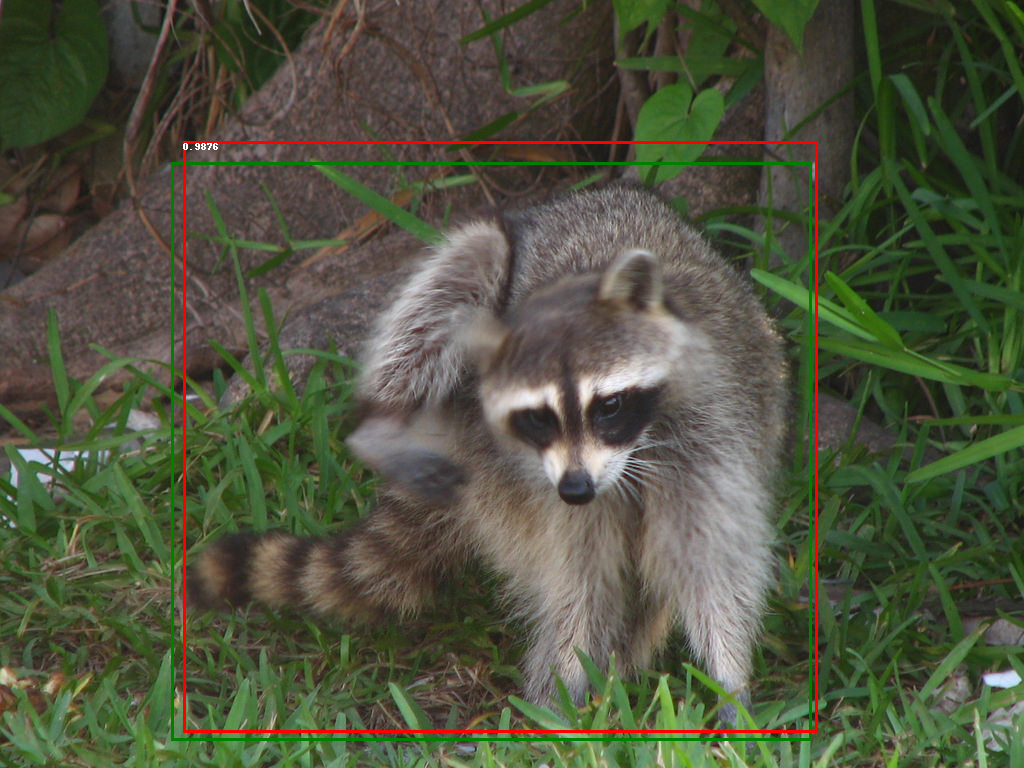

In [ ]:
from PIL import ImageDraw

idx = 0
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
   prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# draw groundtruth
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])], 
   outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   if score > 0.8:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image